# Generate DEA Hotspots animations <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)


## Description
This notebook loads DEA Hotspots data for a given time and location, and animates the data over a 2018 Geomedian underlay with fading colours that represent the age of the hotspot.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
import os
import datacube
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import sys
sys.path.append('../Scripts')
from dea_spatialtools import xr_rasterize

# # Create custom cmap with dark grey at end 
fires_cmap = get_cmap('YlOrRd')
# fires_cmap.set_over('#111211')

dc = datacube.Datacube(app="DEA_hotspots")

# boundary = gpd.read_file('https://data.gov.au/geoserver/nsw-state-boundary/wfs?request=GetFeature&typeName=ckan_a1b278b1_59ef_4dea_8468_50eb09967f18&outputFormat=json')
boundary = gpd.read_file('https://raw.githubusercontent.com/rowanhogan/australian-states/master/states.geojson').simplify(tolerance=0.02)




## Parameters

Set parameters used to load and visualise DEA Hotspots data

In [30]:
# # Setup params
# name = 'actfire'  # name used for output files
# time_period = 15  # days from current date to include in animation (e.g. a month or week of data)
# to_date = (dt.datetime.today() + dt.timedelta(days=1)).strftime('%Y-%m-%d')
# from_date = (dt.datetime.today() - dt.timedelta(days=time_period)).strftime('%Y-%m-%d')
# y_max, x_min = -35.38, 148.68  # top left coordinates of bbox
# y_min, x_max = -36.02, 149.32  # bottom right coordinates of bbox
# min_confidence = 0  # minimum confidence value of hotspots to include in animation
# max_features = 900000  # maximum features to load from WFS
# avhrr=False

# Setup params
name = 'eastcoast'  # name used for output files
from_date = '2019-10-15'
to_date = '2020-02-15'
y_max, x_min = -27.00, 142.5  # top left coordinates of bbox
y_min, x_max = -39.2, 154.7  # bottom right coordinates of bbox
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 2000000  # maximum features to load from WFS
avhrr=False
modis=True
viirs=True

# Visualisation params
frame_freq = '5H'  # frequency used to generate animation frames (e.g. one frame every 3 hours). Smaller numbers create longer, smoother animations but take longer to render
hotspots_markersize = 3  # size to plot hotspots on map
hotspots_alpha = 0.15  # transperancy to plot hotspots on map
fade_hours = 96  # hours used to fade hotspots from yellow to black
geomedian_res = 0.03  # resolution in degrees to load geomedian underlay (smaller = slower rendering)

## Load and clean hotspots data

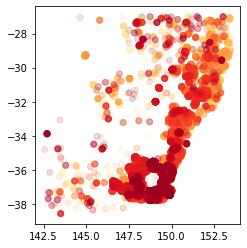

In [31]:
# Load WFS query data
avhrr_string = '(sensor=%27AVHRR%27%20AND%20(product=%27SRSS%27))%20OR%20' if avhrr else ''
modis_string = '(sensor=%27MODIS%27%20AND%20(product=%27MOD14%27))%20OR%20' if modis else ''
viirs_string = '(sensor=%27VIIRS%27%20AND%20(product=%27AFMOD%27%20OR%20product=%27EDR%27))' if viirs else ''
url = f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=({avhrr_string}{modis_string}{viirs_string})%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_min}%20{x_min},%20{y_min}%20{x_max},%20{y_max}%20{x_max},%20{y_max}%20{x_min},%20{y_min}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A"
hotspots_gdf = gpd.read_file(url)
hotspots_gdf

# Filter by confidence
hotspots_gdf = hotspots_gdf.loc[hotspots_gdf.confidence >= min_confidence]

# Fix datetime
hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['start_dt'])

# Extract required columns
hotspots_gdf = hotspots_gdf.loc[:, [
    'datetime', 'latitude', 'longitude', 'temp_kelvin', 'confidence', 'geometry'
]]
hotspots_gdf.sort_values('datetime', ascending=True, inplace=True)
hotspots_gdf.plot(column='datetime', cmap=fires_cmap, alpha=hotspots_alpha)

## Load 2018 geomedian underlay

In [45]:
# Create a query object
query = {
    "time": '2018',
    "x": (x_min, x_max),
    "y": (y_max, y_min),
    "measurements": ["red", "green", "blue"],
    "output_crs": "EPSG:4326",
    "resolution": (-geomedian_res, geomedian_res),
}

ds = dc.load(product="ls8_nbart_geomedian_annual", **query)

boundary_xr = xr_rasterize(gdf=boundary, 
             da=ds.red, 
             x_dim='longitude', 
             y_dim='latitude',
             all_touched=True)

ds = ds.where(boundary_xr, other=0)


Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


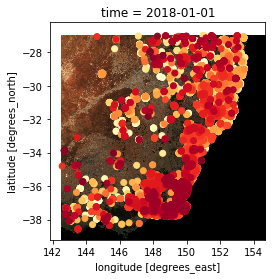

In [46]:
ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(vmax=4000)
hotspots_gdf.plot(ax=plt.gca(), column='datetime', cmap=fires_cmap)

## Generate animation frames

2019-10-15 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


2019-10-15 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-15 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-16 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-17 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-18 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-19 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-20 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-21 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-22 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-23 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-24 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-25 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-26 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-27 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-28 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-29 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-30 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-10-31 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-01 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-02 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-03 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-04 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-05 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-06 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-07 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-08 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-09 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-10 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-11 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-12 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-13 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-14 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-15 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-16 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-17 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-18 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-19 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-20 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-21 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-22 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-23 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-24 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-25 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-26 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-27 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-28 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-29 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-11-30 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-01 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-02 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-03 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-04 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-05 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-06 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-07 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-08 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-09 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-10 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-11 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-12 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-13 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-14 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-15 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-16 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-17 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-18 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-19 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-20 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-21 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-22 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-23 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-24 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-25 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-26 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-27 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-28 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-29 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-30 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2019-12-31 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-01 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-02 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-03 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-04 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-05 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-06 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-07 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-08 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-09 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-10 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-11 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-12 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-12 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-12 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-12 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-13 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-13 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-13 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-13 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-13 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-14 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-14 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-14 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-14 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-14 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-15 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-15 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-15 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-15 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-15 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-16 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-16 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-16 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-16 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-16 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-17 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-17 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-17 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-17 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-18 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-18 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-18 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-18 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-18 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-19 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-19 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-19 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-19 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-19 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-20 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-20 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-20 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-20 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-20 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-21 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-21 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-21 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-21 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-21 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-22 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-22 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-22 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-22 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-23 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-23 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-23 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-23 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-23 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-24 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-24 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-24 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-24 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-24 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-25 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-25 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-25 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-25 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-25 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-26 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-26 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-26 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-26 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-26 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-27 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-27 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-27 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-27 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-28 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-28 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-28 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-28 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-28 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-29 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-30 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-01-31 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-01 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-02 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-03 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-04 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-05 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-06 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-07 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-08 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-09 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 03:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 08:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 13:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 18:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-10 23:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 04:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 09:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 14:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-11 19:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 00:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 05:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 10:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 15:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-12 20:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 01:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 06:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 11:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 16:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-13 21:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 02:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 07:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 12:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 17:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2020-02-14 22:00:00
Rasterizing to match xarray.DataArray dimensions (407, 407) and projection system/CRS (e.g. EPSG:4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


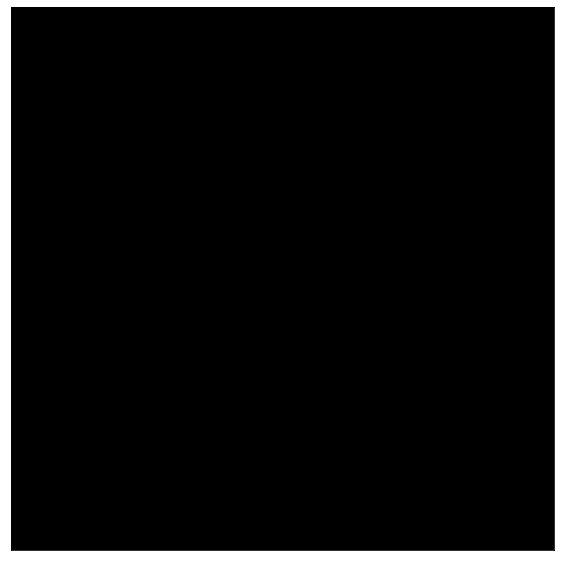

In [47]:
ds_ani = ds.copy(deep=True)

# If output folder doesn't exist, create it
output_dir = f'frames_{name}'
os.makedirs(output_dir, exist_ok=True)

# # Get date/times to iterate through (1 per frame)
# comp_dates = pd.date_range(hotspots_gdf.datetime.min(), 
#                            (dt.datetime.today() + dt.timedelta(days=0.7)), 
#                            freq=frame_freq)

# Get date/times to iterate through (1 per frame)
comp_dates = pd.date_range(from_date, 
                           to_date, 
                           freq=frame_freq)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, comp_date in enumerate(comp_dates):
    
    print(comp_date)

    # Extract only hotspots occuring prior to frame date/time
    hotspots_prev = hotspots_gdf.loc[
        hotspots_gdf['datetime'] < comp_date].copy()
    
    # Calculate hours between frame date and hotspot and sort
    hotspots_prev['hours_before'] = ((
        (comp_date - hotspots_prev['datetime'])).astype('timedelta64[m]') / 60)
    hotspots_prev.sort_values('hours_before', inplace=True, ascending=False)
    
    # Filter to most recent hours
    hotspots_prev = hotspots_prev[hotspots_prev.hours_before < fade_hours]

    # Plot Geomedian as underlay
    try:
        burnt_pixels = xr_rasterize(gdf=hotspots_prev, 
                                        da=ds.red, 
                                        x_dim='longitude', 
                                        y_dim='latitude',
                                        all_touched=True)
        ds_ani = ds_ani * (1 - burnt_pixels * 0.05)
    except:
        pass
    
    ds_ani[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=ax, 
                                                                     vmax=4000)
    
    # Plot hotspots
    hotspots_prev.plot(ax=ax,
                       column='hours_before',
                       cmap=fires_cmap,
                       markersize=hotspots_markersize,
                       alpha=hotspots_alpha,
                       vmin=0,
                       vmax=fade_hours,
                      )
    
    boundary.plot(linestyle=':', edgecolor='white', facecolor='none', ax=plt.gca())
    
    labels = {'Sydney': (151.2093, -33.8688), 
              'Canberra': (149.1300, -35.2809), 
              'Melbourne': (144.9631, -37.8136)}

    for label, (x, y) in labels.items():
        plt.annotate(s=label,
                         xy=(x + 0.25, y), 
                         c='white',
                         fontname='Liberation Sans',
                         fontsize=8), 
    
    # Customise plot and add title
    ax.set_facecolor('black')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('');
    ax.text(0.03, 0.95,
            f"{comp_date.tz_localize(tz='UTC').tz_convert('Australia/Sydney'):%Y-%m-%d}",
            ha='left', 
            va='center', 
            transform=ax.transAxes,
           fontdict={'fontsize': 20, 
                     'color': 'white', 
                     'fontname':'Liberation Sans'})
    
    # Export frame to file
    fig.savefig(f'{output_dir}/hotspots_{i}.png', 
                bbox_inches='tight',
                dpi=100,
                pad_inches=0)
    plt.cla()


## Combine into MP4 animation using FFMPEG

In [49]:
!ffmpeg -y -r 18 -i $output_dir/hotspots_%d.png -c:v libx264 -vf crop=in_w-15:in_h-15 -pix_fmt yuv420p $output_dir/hotspots_animation.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:
!ffmpeg -y -r 24 -i $output_dir/hotspots_%d.png -vf crop=in_w-15:in_h-15,minterpolate=fps=7 $output_dir/hotspots_animation.gif

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)